In [1]:
from tqdm.notebook import tqdm
import pdb # pdb.set_trace()

In [110]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table


# Dlnpyutils
from dlnpyutils.utils import bspline,mad

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Astrologium():
    '''
    A class to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia (E)DR3 and 2MASS photometry.
    '''
    def __init__(self,teff,logg,abund,obsphot,distance,isochrones,ext_law='CCM89',rv=3.1):
        
        '''
        Inputs:
        ------
            teff:       2x1 array-like
                        Teff and error of star np.array([teff,teff_err])
                        
            logg:       2x1 array-like
                        Log(g) and error of star np.array([logg,logg_err])
                    
            abund:      2x1 array-like
                        first column is [M/H] and [Alpha/M] and the second column is the errors
                    
            obs_phot:   6x2 array-like
                        first column is BP, G, RP, J, H, and K and the second column is the errors
                        
            distance:   float
                        distance to star in pc
                    
            isochrones: astropy Table 
                        PARSEC isochrone table
                        
            ext_law:    string, optional
                        extinction law to use. Default is CCM89.
                        
                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022
                        
            rv:         float, optional
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1 
                        (required to be 3.1 if ext_law = 'F99')

        '''
        
        # Teff and log(g)
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.logg  = logg[0] # log(g)
        self.logg_err = logg[1] # log(g) error
        
        # Salaris [Fe/H] Asplund 2021 et al.
        self.salfeh = abund[0,0]+np.log10(0.659*(10**(abund[1,0]))+0.341) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.341/(0.659*(10**(abund[1,0]))+0.341))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # Absolute Magnitudes Not Derreddened
        self.absphot = self.phot-self.distmod
        
        # PARSEC isochrones
        self.labels = ['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.rv = rv
        self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K
        self.extlaw_coeff = self.extcoeff(law=ext_law)
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value

        Inputs:
        ------
            data:  array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value

        Inputs:
        ------
            data:   array-like
                    data to search through

            value:  float or int
                    value of interest

        Output:
        ------
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    ##################
    ### Extinction ###
    ##################
    
    def extcoeff(self,rv=3.1,law='CCM89'):#,ref='G'):

        '''
        Calculate the relative extincion law coefficients for a given wavelength relative to the 
        BP, G, RP, J, H, K or user defined band

        Input:
        -----
            wavelength: float
                        Effective wavelength of band of interest in microns

            law:        str
                        extinction law to use

                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022

            rv:         float
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1

        Output:
        ------
            ext_coeff:  float
                        calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                        relative to the Gaia G band

        '''

        leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

        # select the extinction model
        if law == 'CCM89':
            ext_model = CCM89(Rv=rv)

        elif law == 'O94':
            ext_model = O94(Rv=rv)

        elif law == 'F99':
            ext_model = F99(Rv=rv)

        elif law == 'F04':
            ext_model = F04(Rv=rv)

        elif law == 'VCG04':
            ext_model = VCG04(Rv=rv)

        elif law == 'GCC09':
            ext_model = GCC09(Rv=rv)

        elif law == 'M14':
            ext_model = M14(Rv=rv)

        elif law == 'F19':
            ext_model = F19(Rv=rv)

        elif law == 'D22':
            ext_model = D22(Rv=rv)   

        # Calculate the relative extinction coefficient
        ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))

        return ext_coeff_array
    
    def extinction(self):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and K bands
        
        Output:
        ------
            ext: 6x2 array
                 first column is the extinction values and the second is the errors
            
        '''
        
        # isochrone magnitude labels
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 200 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso #self.iso[teffcut]
        
        # check to make sure teff of star is in range of the isochrone
        if np.size(np.squeeze(teffcut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
    
        # get colors and errors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        # create "reddening" vector (slightly modified from the normal definition)
        red_vec = np.delete(1-self.extlaw_coeff/self.extlaw_coeff[1],1)
        red_vec[0] = -1*red_vec[0]
        
        ext_vec = self.extlaw_coeff/self.extlaw_coeff[1]
        
        # calculate the intrinsic colors using a b-spline
        bspline_vec = 999999.0*np.ones(5)
        bspline_vec_deriv = 999999.0*np.ones(5)
        
        for i in range(5):
            try:
                # Interpolate the color-Teff relation using a b-spline
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
                logTe = iso_['logTe']

                bspl = bspline(logTe,color)
                bspline_vec[i] = bspl(np.log10(self.teff))
                bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
            except:
                try:
                    bspl = bspline(logTe,color,extrapolate=True)
                    bspline_vec[i] = bspl(np.log10(self.teff))
                    bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
                except:
                    bspline_vec[i] = 999999.0
                    bspline_vec_deriv[i] = 999999.0
                
        # calculate the extinctions and errors
        color_diff = obs_colors-bspline_vec
        bspl_errs = np.abs((bspline_vec_deriv*self.teff_err)/(self.teff*np.log(10)))
        color_diff_err = np.sqrt(obs_colors_err**2+bspl_errs**2)

        
        # find bad values this should take care of bad values from the spline
        neg_cut = np.where(color_diff>0)
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            self.ext = 999999.0*np.ones((6,2))
#             pdb.set_trace()
            return 999999.0*np.ones((6,2))
        
        # calculate the extinction value and error
        ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        ag_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        
        ext = 999999.0*np.ones((6,2))
        ext[:,0] = ext_vec*ag
        ext[:,1] = ext_vec*ag_err
        
        self.ext = ext
#         pdb.set_trace()
        return ext
    
    ##############################################
    ### Magnitudes, Extinctions, Ages & Masses ###
    ##############################################
    
    def teff_2_appmags(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff:     float
                      Teff of star 
                      
            age:      float
                      age of star
        
        Output:
        ------
            calc_mag: 6x2 array 
                      expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        extincts = self.ext[:,0]
        
        lgage = np.log10(age*10**9)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                mag_spl = bspline(iso_['logTe'],iso_[self.labels[i]])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                
            lgg_spl = utils.bspline(iso_['logTe'],iso_['logg'])
            calc_logg = lgg_spl(lgteff)
                
            return np.append(calc_mags, calc_logg)    
            
            #return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### use a b-spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                mag_spl_lo = bspline(iso_lo['logTe'],iso_lo[self.labels[i]]) 
                mag_spl_hi = bspline(iso_hi['logTe'],iso_hi[self.labels[i]])
#                 age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
#                                                                  [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                
                age_spl_interp = interp1d([age_lo,age_hi],[mag_spl_lo(lgteff),mag_spl_hi(lgteff)])
                
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                
            lgg_spl_lo = bspline(iso_lo['logTe'],iso_lo['logg'])
            lgg_spl_hi = bspline(iso_hi['logTe'],iso_hi['logg'])
            
            lgg_spl_interp = interp1d([age_lo,age_hi],[lgg_spl_lo(lgteff),lgg_spl_hi(lgteff)])
            
            calc_logg = lgg_spl_interp(age)

            return np.append(calc_mags, calc_logg)
    
    def get_age(self,guess_ages=np.linspace(0.,17.)[::10],verbose=False):
        '''
        Find best fitting age for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: array 
                        initial guesses for ages in Gyr

            
        Output:
        ------
            age:        float 
                        best age according to chi^2 space search
                        
            chi:        float
                        best chi^2 according to chi^2 space search
                        
            rms:        float
                        RMSE of the result
            
        '''
            
        # initialize lists
        
        curve_ages = []
        curve_chi = []
        curve_rms = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
#             try:
            # calculate best fit parameters and covariance matrix
            obs_quants = np.append(np.copy(self.phot),self.logg)
            obs_quants_err = np.append(np.copy(self.phot_err),self.logg_err)


            popt,pcov = curve_fit(self.teff_2_appmags,self.teff,obs_quants,p0=guess_ages[j],
                                  method='lm',sigma=obs_quants_err,
                                  absolute_sigma=True,maxfev=5000)

            # populate lists
            curve_ages.append(popt[0])
            curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0]))

            curve_chi.append(sum((curve_mags-obs_quants)**2/obs_quants_err**2))
            curve_rms.append(np.std(curve_mags-obs_quants))
#                 curve_rms.append(np.sqrt(sum((curve_mags-obs_quants)**2)/len(curve_mags)))

#             except:
#                 # populate lists
#                 curve_ages.append(999999.0)
#                 curve_chi.append(999999.0)
#                 curve_rms.append(999999.0)
            print(curve_ages)
            print(popt)
    
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        age = np.asarray(curve_ages)[idx]
        chi = np.asarray(curve_chi)[idx]
        rms = np.asarray(curve_rms)[idx]
        self.age = age
        self.chi = chi
        self.rms = rms

        pdb.set_trace()
        return age, chi, rms
    
    ##############
    ### Masses ###
    ##############
    
    def age_2_mass(self,age):
        '''
        Calculate the mass of a star from its age
        
        Input:
        -----
            age:      2x1 array
                      age of a star in Gyr and associated error

        Output:
        ------
            mass:     float 
                      mass of star in solar masses
            
            mass_err: float
                      error in the calculated mass of the star
        '''

        if self.age == 999999.0:
            return 999999.0
#             return np.array([999999.0,999999.0])
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            return 999999.0
#             return np.array([999999.0,999999.0])
        try:
            ### calculate the mass and error using interpolation
            bspl = bspline(iso_['logAge'],iso_['Mass'])
            mass = bspl(np.log10(age*10**9))
            
        except:
            mass = 999999.0

        if np.isfinite(mass)==False:
            return 999999.0
        
        return mass

In [108]:
import MagellanicStream as MagellanicStream

def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data:   array-like
                data to search through

        value:  float or int
                value of interest

    Output:
    ------
        close1: float or int
                closest value under the given value

        close2: float or int
                closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 with parameters from Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y) using equation 6 form Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

# PARSEC

In [4]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive = massive[np.argsort(massive['logAge'])]
massive = massive['MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']
# I noticed that there's some weird points marked as RGB, so I cut those out with
cut = np.poly1d(np.polyfit([4600,5400],[0.5,2],1))
massive = massive[np.where(massive['logg']>cut(10**massive['logTe']))]

# APOGEE 

In [54]:
calib = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/apogee_library_dr17_rev1.fits')
cn = calib['fparam'][:,4]-calib['fparam'][:,5]
dt = calib['teff_spec'] - (4400.+552.6*(calib['logg_spec']-2.5)-324.6*calib['fparam'][:,3])

rc = calib[np.where((calib['fparam'][:,1]>1.5)&(calib['fparam'][:,1]<3.5)&
                   (cn>0.04-0.46*calib['fparam'][:,3]-0.0028*dt))]

rgb_all = calib[np.where((calib['fparam'][:,1]<3.5)&(calib['fparam'][:,0]<6000.)&
                    (np.isin(calib['apogee_id'],rc['apogee_id'])==False))]

# Get rid of high extinction stars
rgb = rgb_all[np.where((rgb_all['sfd_ebv']<0.03))]

In [13]:
lmcdr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17rev1_qacuts.fits.gz')

apoafe = lmcdr17['ALPHA_M']+lmcdr17['M_H']-lmcdr17['FE_H']
apoafe_err = np.sqrt(lmcdr17['ALPHA_M_ERR']**2+lmcdr17['M_H_ERR']**2+lmcdr17['FE_H']**2)

salfeh = lmcdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(lmcdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe))+0.341))*apoafe_err)**2)

diane = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/output_LMC_DR16_all.fits.gz')

_, diane_idx, me_idx = np.intersect1d(diane['APOGEE_ID'],lmcdr17['APOGEE_ID'], return_indices=True)

In [6]:
from dlnpyutils import coords
import astropy.units as u
from astropy.coordinates import SkyCoord

lmcx, lmcy, lmcdis = LMCdisk_cart(lmcdr17['RA'], lmcdr17['DEC'])
lmcr = elliptical_radius(lmcx,lmcy)

### lmcdr17
gc = SkyCoord(ra=lmcdr17['RA']*u.degree, dec=lmcdr17['DEC']*u.degree, frame='icrs')
lms_lmc,bms_lmc = coords.gal2mag(gc.galactic.l.value,gc.galactic.b.value)

for i in range(len(lms_lmc)):
    if lms_lmc[i] > 180.:
        lms_lmc[i] = lms_lmc[i]-360

In [7]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

In [8]:
from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

bperrfunc = bspline(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = bspline(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = bspline(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

In [9]:
from scipy.interpolate import BSpline


teff_tck = (np.array([3527.46704102, 3527.46704102, 3527.46704102, 3527.46704102, 3708.91847923, 3890.36991744, 
                      4071.82144442, 4253.27263849, 4434.72434304, 4616.17578125, 4797.62695312, 4979.07848011,
                      5160.53018466, 5341.98144531, 5523.43261719, 5523.43261719, 5523.43261719, 5523.43261719]),
            np.array([ -36.38271977,  -43.37201334,  -17.08585409,   67.8896712 , 69.84606503,  100.46933976,  
                      103.94758719,   75.90855137,60.21227975,   -5.14343676,   -6.42134699,  217.36965544,
                      -447.26168354, -197.7697192 ,    0.        ,    0.        , 0.        ,    0.        ]),3)


tcorr_spl = BSpline(teff_tck[0],teff_tck[1],teff_tck[2])

tcorr = tcorr_spl(lmcdr17['FPARAM'][:,0])+lmcdr17['FPARAM'][:,0]

mh_tck = (np.array([-2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -1.96716837e+00,
                    -1.71575650e+00, -1.46434463e+00, -1.21293276e+00, -9.61520889e-01, -7.10109077e-01,
                    -4.58697175e-01, -2.07285313e-01, 4.41265486e-02, 2.95538409e-01, 5.46950281e-01, 
                    5.46950281e-01, 5.46950281e-01, 5.46950281e-01]),
          np.array([1.12848696e+02, 1.00546777e+02, 1.15992357e+02, 9.79509398e+01, 3.87315323e+01, 
                    1.86357031e+01, -1.50821811e+01, 1.21509274e+01, 6.69424869e+00, -2.90025110e+00,
                    -2.68067104e+01, -3.13392475e+01, -8.25826363e+01,-6.49082047e+01, 0.00000000e+00, 
                    0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),3)

teff_cal = BSpline(mh_tck[0],mh_tck[1],mh_tck[2])(lmcdr17['FPARAM'][:,3])+tcorr

In [10]:
agetab = fits.getdata('lmc_dr17_lm_calteff_31AUG2022.fits')
ygridage = np.where(agetab['AGE']==0.0)
ygridage

(array([   1,    2,    3,    4,   24,   25,   29,   33,   36,   38,   43,
          72,   83,   85,   87,   97,  112,  115,  122,  123,  130,  131,
         137,  142,  148,  157,  160,  162,  163,  171,  187,  196,  211,
         335,  346,  363,  376,  379,  396,  404,  431,  438,  440,  460,
         463,  467,  473,  474,  477,  478,  482,  489,  491,  502,  515,
         526,  527,  533,  546,  556,  560,  569,  572,  576,  578,  581,
         586,  587,  588,  591,  595,  603,  612,  618,  620,  640,  641,
         659,  665,  668,  679,  680,  687,  697,  705,  708,  709,  714,
         716,  735,  746,  750,  774,  777,  792,  797,  803,  809,  816,
         823,  827,  837,  846,  859,  860,  866,  870,  877,  883,  884,
         886,  892,  894,  901,  905,  913,  925,  929,  940,  948,  953,
         961,  970,  971,  984,  985,  987,  990,  994,  998, 1009, 1024,
        1032, 1040, 1046, 1052, 1057, 1074, 1107, 1113, 1119, 1137, 1138,
        1143, 1145, 1158, 1159, 1166, 

In [111]:
_ext = 999999.0*np.ones((len(lmcdr17[ygridage]),6))
_ext_err = 999999.0*np.ones((len(lmcdr17[ygridage]),6))
_age = 999999.0*np.ones(len(lmcdr17[ygridage]))
_chi = 999999.0*np.ones(len(lmcdr17[ygridage]))
_rms = 999999.0*np.ones(len(lmcdr17[ygridage]))
_mass = 999999.0*np.ones(len(lmcdr17[ygridage]))

for i in tqdm(range(len(lmcdr17[ygridage]))):
    
    # Initialize Aetas 
#     te = np.array([lmcdr17['TEFF'][ygridage][i],lmcdr17[ygridage]['TEFF_ERR'][i]])
    
    te = np.array([teff_cal[ygridage][i],lmcdr17[ygridage]['TEFF_ERR'][i]])
    
    lg = np.array([lmcdr17[ygridage]['LOGG'][i],lmcdr17[ygridage]['LOGG_ERR'][i]])
    
    ab = np.array([[lmcdr17[ygridage]['FE_H'][i],apoafe[ygridage][i]],
                   [lmcdr17[ygridage]['FE_H_ERR'][i],apoafe_err[ygridage][i]]]).T
    
    op = np.array([[lmcdr17[ygridage]['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    lmcdr17[ygridage]['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    lmcdr17[ygridage]['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    lmcdr17[ygridage]['J'][i],lmcdr17[ygridage]['H'][i],lmcdr17[ygridage]['K'][i]],
                   [bperr[ygridage][i],gerr[ygridage][i],rperr[ygridage][i],lmcdr17[ygridage]['J_ERR'][i],
                    lmcdr17[ygridage]['H_ERR'][i],lmcdr17[ygridage]['K_ERR'][i]]]).T
    
    di = lmcdis[i]*1000

    CalcAge = Astrologium(te,lg,ab,op,di,massive)
    
    exts = CalcAge.extinction()
    _ext[i,:],_ext_err[i,:] = exts[:,0],exts[:,1]
    
    _age[i],_chi[i],_rms[i] = CalcAge.get_age()
    _mass[i] = CalcAge.age_2_mass(_age[i])

  0%|          | 0/497 [00:00<?, ?it/s]

<ipython-input-110-83dbf8298263>:358: RuntimeWarning: divide by zero encountered in log10
  lgage = np.log10(age*10**9)


[0.0]
[0.]
[0.0, 3.4693877551020407]
[3.46938776]
[0.0, 3.4693877551020407, 6.938775510204081]
[6.93877551]
[0.0, 3.4693877551020407, 6.938775510204081, 10.408163265306122]
[10.40816327]
[0.0, 3.4693877551020407, 6.938775510204081, 10.408163265306122, 13.877551020408163]
[13.87755102]
> <ipython-input-110-83dbf8298263>(495)get_age()
    493 
    494         pdb.set_trace()
--> 495         return age, chi, rms
    496 
    497     ##############



<ipython-input-110-83dbf8298263>:533: RuntimeWarning: divide by zero encountered in log10
  mass = bspl(np.log10(age*10**9))
Exception ignored in: <function tqdm.__del__ at 0x7fcb57bf0dc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py", line 1161, in __del__
    def __del__(self):
KeyboardInterrupt: 


--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
[0.0]
[0.]
[0.0, 3.4693877551020407]
[3.46938776]
[0.0, 3.4693877551020407, 6.938775510204081]
[6.93877551]
[0.0, 3.4693877551020407, 6.938775510204081, 10.408163265306122]
[10.40816327]
[0.0, 3.4693877551020407, 6.938775510204081, 10.408163265306122, 13.877551020408163]
[13.87755102]
> <ipython-input-110-83dbf8298263>(495)get_age()
    493 
    494         pdb.set_trace()
--> 495         return age, chi, rms
    496 
    497     ##############

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
[0.0]
[0.]
[0.0, 3.4693877551020407]
[3.46938776]
[0.0, 3.4693877551020407, 6.938775510204081]
[6.93877551]
[0.0, 3.4693877551020407, 6.938775510204081, 10.408163265306122]
[10.40816327]
[0.0, 3.4693877551020407, 6.938775510204081, 10.408163265306122, 13.877551020408163]
[13.87755102]
> <ipython-input-110-83dbf8298263>(495)get_age()
    493 
    494         pdb.set_trace()
--> 495         return age, chi, rms
    496 
    

KeyboardInterrupt: 

(array([  0.,   0.,   0.,   0.,   0., 497.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

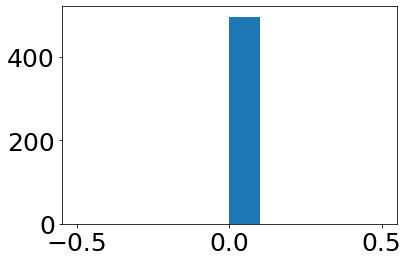

In [99]:
plt.hist(_age)

In [83]:
trace_ext = 999999.0*np.ones((len(lmcdr17[ygridage]),6))
trace_ext_err = 999999.0*np.ones((len(lmcdr17[ygridage]),6))
trace_age = 999999.0*np.ones(len(lmcdr17[ygridage]))
trace_chi = 999999.0*np.ones(len(lmcdr17[ygridage]))
trace_rms = 999999.0*np.ones(len(lmcdr17[ygridage]))
trace_mass = 999999.0*np.ones(len(lmcdr17[ygridage]))

for i in tqdm(range(len(lmcdr17[ygridage]))):
    
    # Initialize Aetas 
    te = np.array([lmcdr17['TEFF'][ygridage][i],lmcdr17[ygridage]['TEFF_ERR'][i]])
    
#     te = np.array([tefftrace_cal[ygridage][i],lmcdr17[ygridage]['TEFFtrace_ERR'][i]])
    
    lg = np.array([lmcdr17[ygridage]['LOGG'][i],lmcdr17[ygridage]['LOGG_ERR'][i]])
    
    ab = np.array([[lmcdr17[ygridage]['FE_H'][i],apoafe[ygridage][i]],
                   [lmcdr17[ygridage]['FE_H_ERR'][i],apoafe_err[ygridage][i]]]).T
    
    op = np.array([[lmcdr17[ygridage]['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    lmcdr17[ygridage]['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    lmcdr17[ygridage]['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    lmcdr17[ygridage]['J'][i],lmcdr17[ygridage]['H'][i],lmcdr17[ygridage]['K'][i]],
                   [bperr[ygridage][i],gerr[ygridage][i],rperr[ygridage][i],lmcdr17[ygridage]['J_ERR'][i],
                    lmcdr17[ygridage]['H_ERR'][i],lmcdr17[ygridage]['K_ERR'][i]]]).T
    
    di = lmcdis[i]*1000

    CalcAge = Astrologium(te,lg,ab,op,di,massive)
    
    exts = CalcAge.extinction()
    trace_ext[i,:],trace_ext_err[i,:] = exts[:,0],exts[:,1]

  0%|          | 0/497 [00:00<?, ?it/s]

KeyboardInterrupt: 

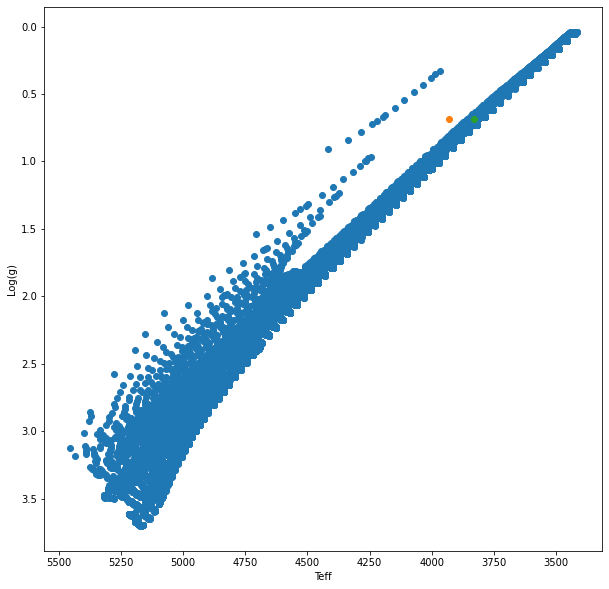

In [19]:
bad_iso = massive[np.where(massive['MH']==closest(massive['MH'],salfeh[ygridage][i]))]

i = 15
plt.figure(figsize=[10,10])
plt.scatter(10**bad_iso['logTe'],bad_iso['logg'])
plt.scatter(lmcdr17['TEFF'][ygridage][i],lmcdr17['LOGG'][ygridage][i])
plt.scatter(teff_cal[ygridage][i],lmcdr17['LOGG'][ygridage][i])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

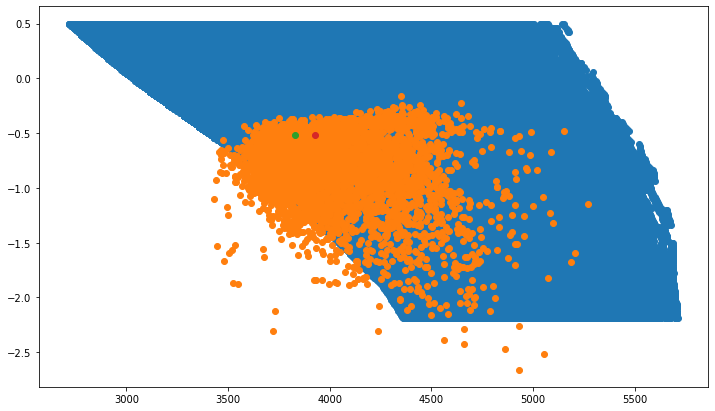

In [27]:
i = 15
plt.figure(figsize=[12,7])
plt.scatter(10**massive['logTe'],massive['MH'])
plt.scatter(teff_cal,salfeh)
plt.scatter(teff_cal[ygridage][i],salfeh[ygridage][i])
plt.scatter(lmcdr17['TEFF'][ygridage][i],salfeh[ygridage][i])
plt.show()

In [44]:
bad_ext = np.where(_ext[:,1]>100.)

In [46]:
len(_ext[bad_ext])

72

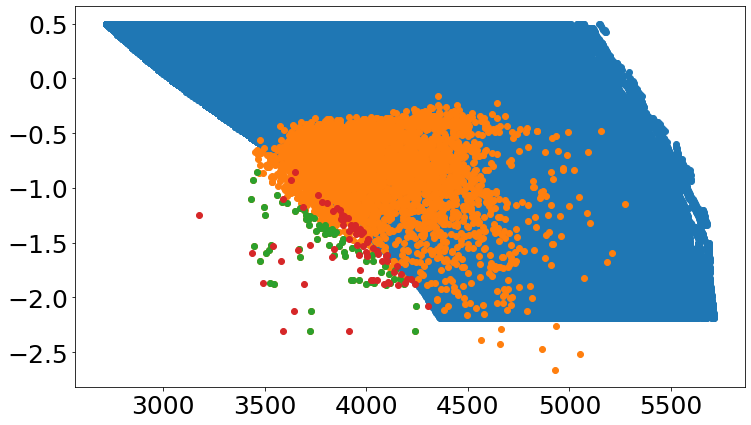

In [48]:
plt.figure(figsize=[12,7])
plt.scatter(10**massive['logTe'],massive['MH'])
plt.scatter(teff_cal,salfeh)
plt.scatter(teff_cal[ygridage][bad_ext],salfeh[ygridage][bad_ext])
plt.scatter(lmcdr17['TEFF'][ygridage][bad_ext],salfeh[ygridage][bad_ext])
plt.show()

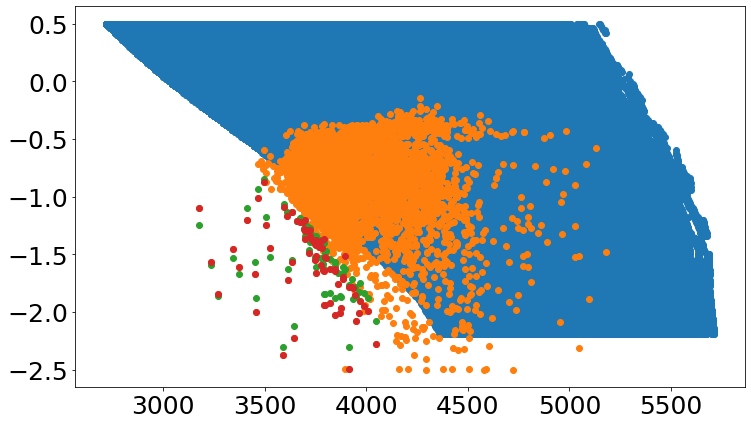

In [50]:
plt.figure(figsize=[12,7])
plt.scatter(10**massive['logTe'],massive['MH'])
plt.scatter(lmcdr17['FPARAM'][:,0],lmcdr17['FPARAM'][:,3])
plt.scatter(lmcdr17['FPARAM'][:,0][ygridage][bad_ext],salfeh[ygridage][bad_ext])
plt.scatter(lmcdr17['FPARAM'][:,0][ygridage][bad_ext],lmcdr17['FPARAM'][:,3][ygridage][bad_ext])
plt.show()

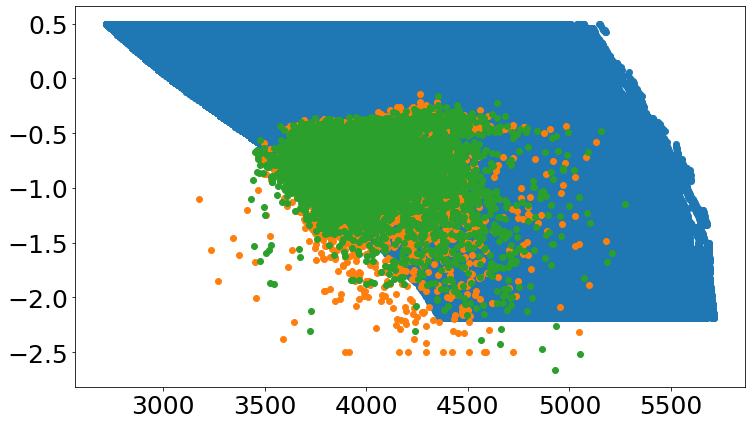

In [53]:
plt.figure(figsize=[12,7])
plt.scatter(10**massive['logTe'],massive['MH'])
plt.scatter(lmcdr17['FPARAM'][:,0],lmcdr17['FPARAM'][:,3])
plt.scatter(teff_cal,salfeh)
# plt.scatter(teff_cal[ygridage],salfeh[ygridage])
# plt.scatter(lmcdr17['FPARAM'][:,0][ygridage][bad_ext],lmcdr17['FPARAM'][:,3][ygridage][bad_ext])
plt.show()

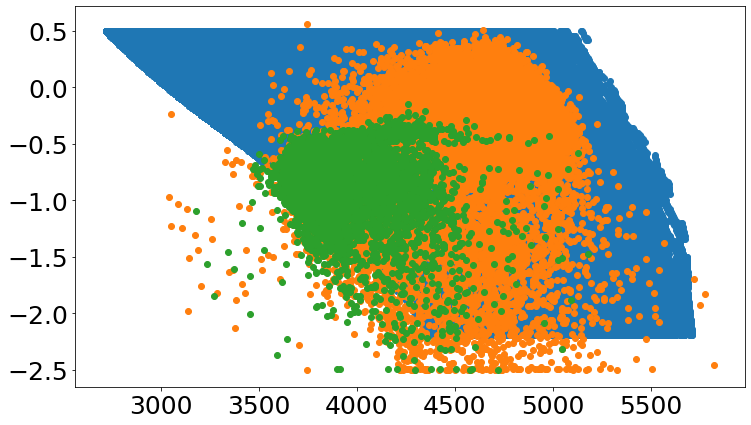

In [55]:
plt.figure(figsize=[12,7])
plt.scatter(10**massive['logTe'],massive['MH'])
plt.scatter(rgb['FPARAM'][:,0],rgb['FPARAM'][:,3])
plt.scatter(lmcdr17['FPARAM'][:,0],lmcdr17['FPARAM'][:,3])
# plt.scatter(teff_cal[ygridage],salfeh[ygridage])
# plt.scatter(lmcdr17['FPARAM'][:,0][ygridage][bad_ext],lmcdr17['FPARAM'][:,3][ygridage][bad_ext])
plt.show()